In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Definition of reference library:

In [8]:
Name = ['approach_swim','slow1','slow2','burst_swim','J_turn','high_angle_turn','routine_turn','spot_avoidance_turn','O_bend','long_latency_C_start','C_start']
Color = ['#82cfff','#4589ff','#0000c8','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']


In [9]:
#arr = np.load('TemplateLong_Tu.npz')
arr = np.load('TemplateHierarchical_Tu.npz')
bouts = arr['bouts']
labels = arr['labels']

# Relabel:
N_clust = len(np.unique(labels))
print(N_clust)
new_labels = np.zeros_like(labels)
for i,l in enumerate(np.unique(labels)):
    new_labels[labels==l]=i

tail = bouts[:,:7,:]
traj = bouts[:,7:,:]

#params = dict(fps=700,peak_loc=35,bout_duration=180)
params = dict(fps=700,peak_loc=30,bout_duration=170)

bouts_dict = dict(
    name = Name,
    color = Color,
    tail = tail,
    traj = traj,
    labels = new_labels,
    params = params,
    )

11


In [10]:

with open('Bouts_dict.pickle', 'wb') as handle:
    pickle.dump(bouts_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Make Knn_Training_Dataset from Bouts Dict:

In [33]:
import numpy as np
#from scipy.ndimage import zoom
from megabouts.super_resolution.downsampling import create_downsampling_function
from scipy.ndimage.interpolation import shift
from dataclasses import dataclass,field
from megabouts.utils.utils_bouts import NameCat
from pathlib import Path

C:\Users\adrien\AppData\Local\Temp\ipykernel_48312\1176803170.py:4: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [34]:

with open('Bouts_dict.pickle', 'rb') as handle:
    bouts_dict = pickle.load(handle)

In [119]:
from megabouts.super_resolution.downsampling import convert_ms_to_frames

In [120]:
@dataclass(repr=False)

class Knn_Training_Dataset():
    

    fps: int
    augmentation_delays: np.ndarray
    bouts_dict: dict
    
    bout_duration: int = field(init=True)
    peak_loc: int = field(init=True)
    
    _bouts: np.ndarray = field(init=False)
    labels: np.ndarray = field(init=False)
    labels_str : np.ndarray = field(init=False)
    delays : np.ndarray = field(init=False)
    
    def __post_init__(self):
        
        bouts = np.concatenate((self.bouts_dict['tail'],self.bouts_dict['traj']),axis=1)
        labels = self.bouts_dict['labels']
        
        bouts = self._downsample(bouts)
        print(bouts.shape)
        bouts,labels,delays = self._augment_with_delays(bouts,labels)
        bouts,labels,delays = self._augment_with_negative(bouts, labels,delays)

        self._bouts = bouts
        self.labels = labels.astype('int')
        self.delays = delays

    @property
    def tail_and_traj(self):
        return self._bouts

    @property    
    def tail(self):
        return self._bouts[:,:7,:]
    
    @property
    def traj(self):
        return self._bouts[:,7:,:]

    @property
    def tail_and_traj_flat(self):
        return self._flatten(self.tail_and_traj)
    
    @property
    def tail_flat(self):
        return self._flatten(self.tail)
    
    @property
    def traj_flat(self):
        return self._flatten(self.traj)


    def _downsample(self,bouts,axis=2):
        
        fps_origin = self.bouts_dict['params']['fps']
        bouts_duration_origin_ms = self.bouts_dict['params']['bout_duration']*1000/fps_origin
        downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=self.fps,fps_origin=fps_origin,duration_ms=bouts_duration_origin_ms)
        return downsampling_f(bouts,axis=axis)

    def _augment_with_delays(self,bouts,labels):
        
        # Routine to check if delay range is valid:
        
        
        original_bout_duration = bouts_dict['params']['bout_duration']
        original_bout_duration_ms = self.bouts_dict['params']['bout_duration']
        target_bout_duration = self.bout_duration
        
        original_peak_loc_ms = bouts_dict['params']['peak_loc']*1000/bouts_dict['params']['fps']
        original_peak_loc = convert_ms_to_frames(self.fps,original_peak_loc_ms) 
        target_peak_loc = self.peak_loc
        
        MaxPosShift = original_bout_duration-target_bout_duration
        MinPeakLoc = max(1,original_peak_loc-MaxPosShift) # We don't allow to miss the first peak so it as to be located at 1 minimum
        MaxPeakLoc = original_peak_loc
        # augmentation_FirstHalfBeatLoc = np.arange(MinPeakLoc,MaxPeakLoc)
        # augmentation_delays =augmentation_FirstHalfBeatLoc-20
        
        # Prepare Variable to store delayed tail
        N_delay = len(self.augmentation_delays)
        N_bouts = bouts.shape[0]
        N_feat = bouts.shape[1]
        N_timestep = self.bout_duration
        
        bouts_rolled = np.zeros((N_bouts*N_delay,N_feat,N_timestep))
        labels_rolled,delays_rolled = np.nan*np.ones(N_bouts*N_delay),np.nan*np.ones(N_bouts*N_delay)
        
        iter_=0
        print(f'TimeStep:{N_timestep},OriginalPeakLoc:{original_peak_loc},TargetPeak:{target_peak_loc}')
        for t in self.augmentation_delays:
            id_st = (original_peak_loc-t)-target_peak_loc
            print(id_st)
            bouts_rolled[iter_:iter_+N_bouts,:,:] = bouts[:,:,id_st:id_st+N_timestep] #shift(bouts,(0,0,t),mode='nearest')
            labels_rolled[iter_:iter_+N_bouts] = labels
            delays_rolled[iter_:iter_+N_bouts] = t
            iter_ = iter_+N_bouts

        
        return bouts_rolled,labels_rolled,delays_rolled
    
    def _augment_with_negative(self,bouts,labels,delays):
        num_cat = len(np.unique(labels))
        flipped = np.copy(bouts)
        flipped[:,[0,1,2,3,4,5,6,8,9]] = -flipped[:,[0,1,2,3,4,5,6,8,9]] # We only tail, flip y and bodyangle to get the symetric bouts
        
        bouts = np.vstack((bouts,flipped))
        labels = np.concatenate((labels,labels+num_cat))
        delays = np.concatenate((delays,delays))
        return bouts,labels,delays

    def _flatten(self,array):
        array_flat = np.reshape(array,(array.shape[0],array.shape[1]*array.shape[2]))
        return array_flat


In [136]:
knn_training_dataset = Knn_Training_Dataset(fps = 700,
                                            augmentation_delays = [-5],
                                            bouts_dict = bouts_dict,
                                            bout_duration = 140,
                                            peak_loc = 20)

(1815, 10, 160)
TimeStep:140,OriginalPeakLoc:35,TargetPeak:20
20


In [137]:
tail = knn_training_dataset.tail

In [138]:
tail.shape

(3630, 7, 140)

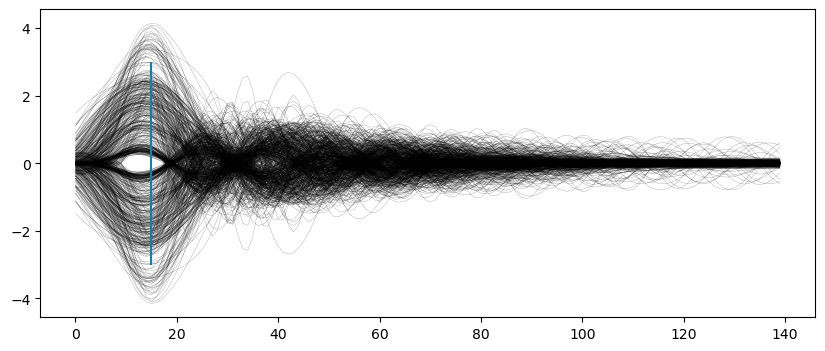

In [139]:
plt.figure(figsize=(10,4))
plt.plot(tail[::5,-1,:].T,'k',lw=0.1)
plt.vlines(15,-3,3)
plt.show()

In [129]:
-5*1000/700

-7.142857142857143

In [134]:
15*1000/700

21.428571428571427

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(tail[::10,-1,:].T,'k',lw=0.1)
plt.vlines(20,-3,3)
plt.show()

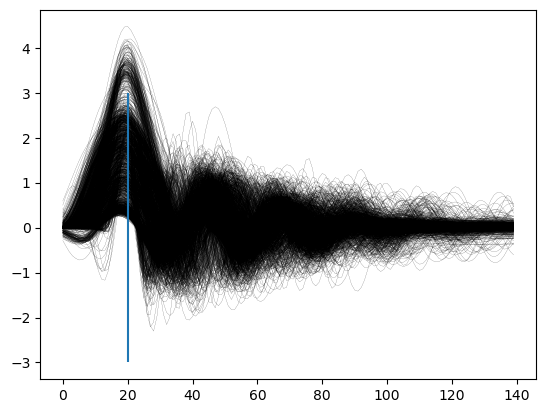

In [88]:
plt.plot(bouts_rolled[delays_rolled==0,6,:].T,'k',lw=0.1)
plt.vlines(20,-3,3)
plt.show()

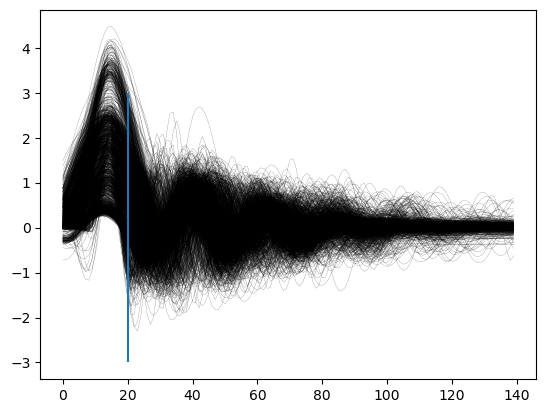

In [89]:
plt.plot(bouts_rolled[delays_rolled==-5,6,:].T,'k',lw=0.1)
plt.vlines(20,-3,3)
plt.show()

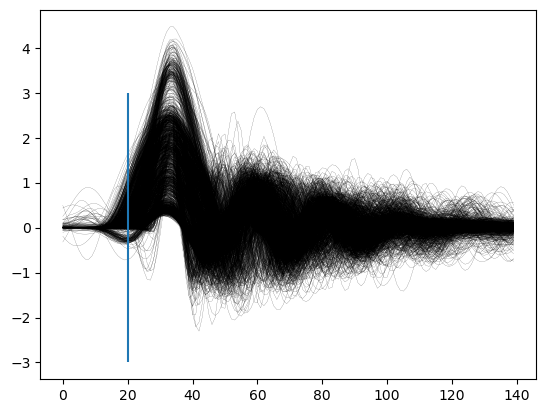

In [90]:
plt.plot(bouts_rolled[delays_rolled==14,6,:].T,'k',lw=0.1)
plt.vlines(20,-3,3)
plt.show()

In [ ]:


    
    def _augment_with_negative(self,bouts,labels,delays):
        flipped = np.copy(bouts)
        flipped[:,[0,1,2,3,4,5,6,8,9]] = -flipped[:,[0,1,2,3,4,5,6,8,9]] # We only tail, flip y and bodyangle to get the symetric bouts
        
        bouts = np.vstack((bouts,flipped))
        labels = np.concatenate((labels,labels+13))
        delays = np.concatenate((delays,delays))
        return bouts,labels,delays

    def _flatten(self,array):
        array_flat = np.reshape(array,(array.shape[0],array.shape[1]*array.shape[2]))
        return array_flat


In [ ]:

pipeline.knn_training_dataset

### Augment with Delays:

In [ ]:
# Define Reference bouts using Dict:

For each category:
    Name
    Color
    Tail
    Trajectory


In [ ]:

NameCatSym = ['approach_swim','slow1','slow2','slow_capture_swim','fast_capture_swim','burst_swim','J_turn','high_angle_turn','routine_turn','spot_avoidance_turn','O_bend','long_latency_C_start','C_start']
NameCat = [s+'+' for s in NameCatSym] + [s+'-' for s in NameCatSym]#[::-1] 
    
    

In [ ]:


list_color_no_CS = ['#82cfff','#4589ff','#0000c8','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']
list_color_w_CS = ['#82cfff','#4589ff','#0000c8','#5d5d66','#000000','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']

NameCatSym_w_CS=['approach_swim', 'slow1', 'slow2', 'slow_capture_swim','fast_capture_swim', 'burst_swim', 'J_turn', 'high_angle_turn','routine_turn', 'spot_avoidance_turn', 'O_bend','long_latency_C_start', 'C_start']
NameCatSym_no_CS=['approach_swim', 'slow1', 'slow2', 'burst_swim', 'J_turn', 'high_angle_turn','routine_turn', 'spot_avoidance_turn', 'O_bend','long_latency_C_start', 'C_start']


cmp_bouts = colors.ListedColormap(list_color_w_CS)
cmp_bouts.set_under(color='white')
cmp_bouts.set_over(color='white')
cmp_bouts.set_bad(color='grey', alpha=None)

In [48]:
knn_training_dataset.augmentation_delays

[0]

In [38]:
140*1000/700

200.0

In [39]:
160*1000/700

228.57142857142858

In [27]:
knn_training_dataset = Knn_Training_Dataset(fps=700,
                                            augmentation_delays=[0],
                                            ignore_CS=True,
                                            filename_template='TemplateFromkNNLong_Tu.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\adrien\\anaconda3\\envs\\ml\\lib\\site-packages\\megabouts\\classification\\TemplateFromkNNLong_Tu.npz'

In [ ]:
        N_delay = len(self.augmentation_delays)
        N_bouts = bouts.shape[0]
        N_feat = bouts.shape[1]
        N_timestep = bouts.shape[2]

        bouts_rolled = np.zeros((N_bouts*N_delay,N_feat,N_timestep))
        labels_rolled,delays_rolled = np.nan*np.ones(N_bouts*N_delay),np.nan*np.ones(N_bouts*N_delay)
        
        iter_=0
        for t in self.augmentation_delays:
            bouts_rolled[iter_:iter_+N_bouts,:,:] = shift(bouts,(0,0,t),mode='nearest')
            labels_rolled[iter_:iter_+N_bouts] = labels
            delays_rolled[iter_:iter_+N_bouts] = t
            iter_ = iter_+N_bouts
        # For shift this method isn't the best

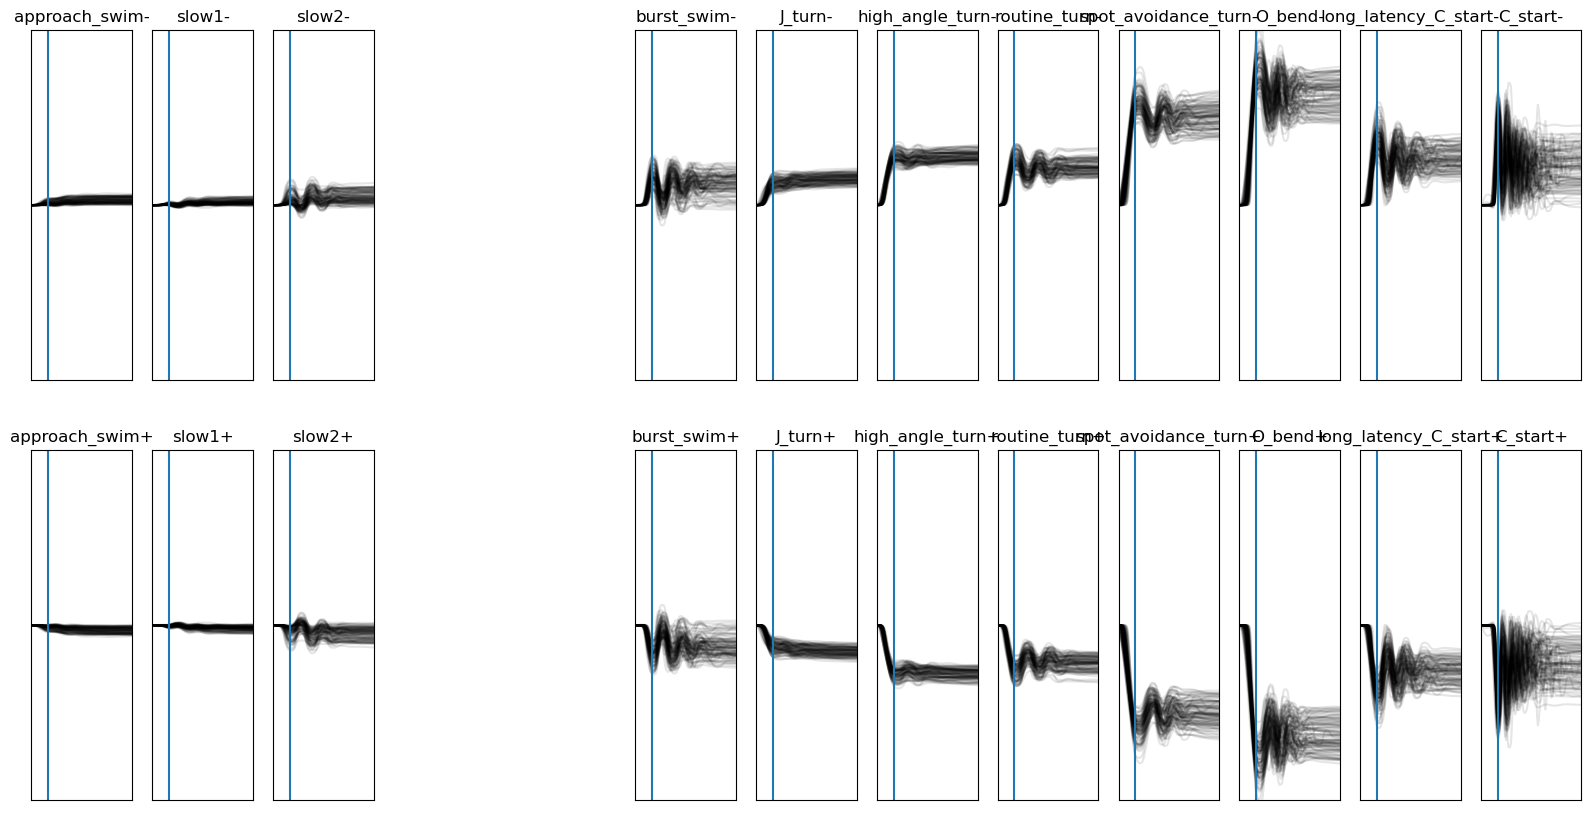

In [22]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = id[0:100]
        ax0.plot(knn_training_dataset.traj[id,-1,:].T,'k',alpha=0.1)

    ax0.vlines(20,-3.6,3.6)
    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [23]:
knn_training_dataset = Knn_Training_Dataset(fps=700,
                                            augmentation_delays=[0],
                                            ignore_CS=True,
                                            filename_template='kNN_Training_Dataset.npz')

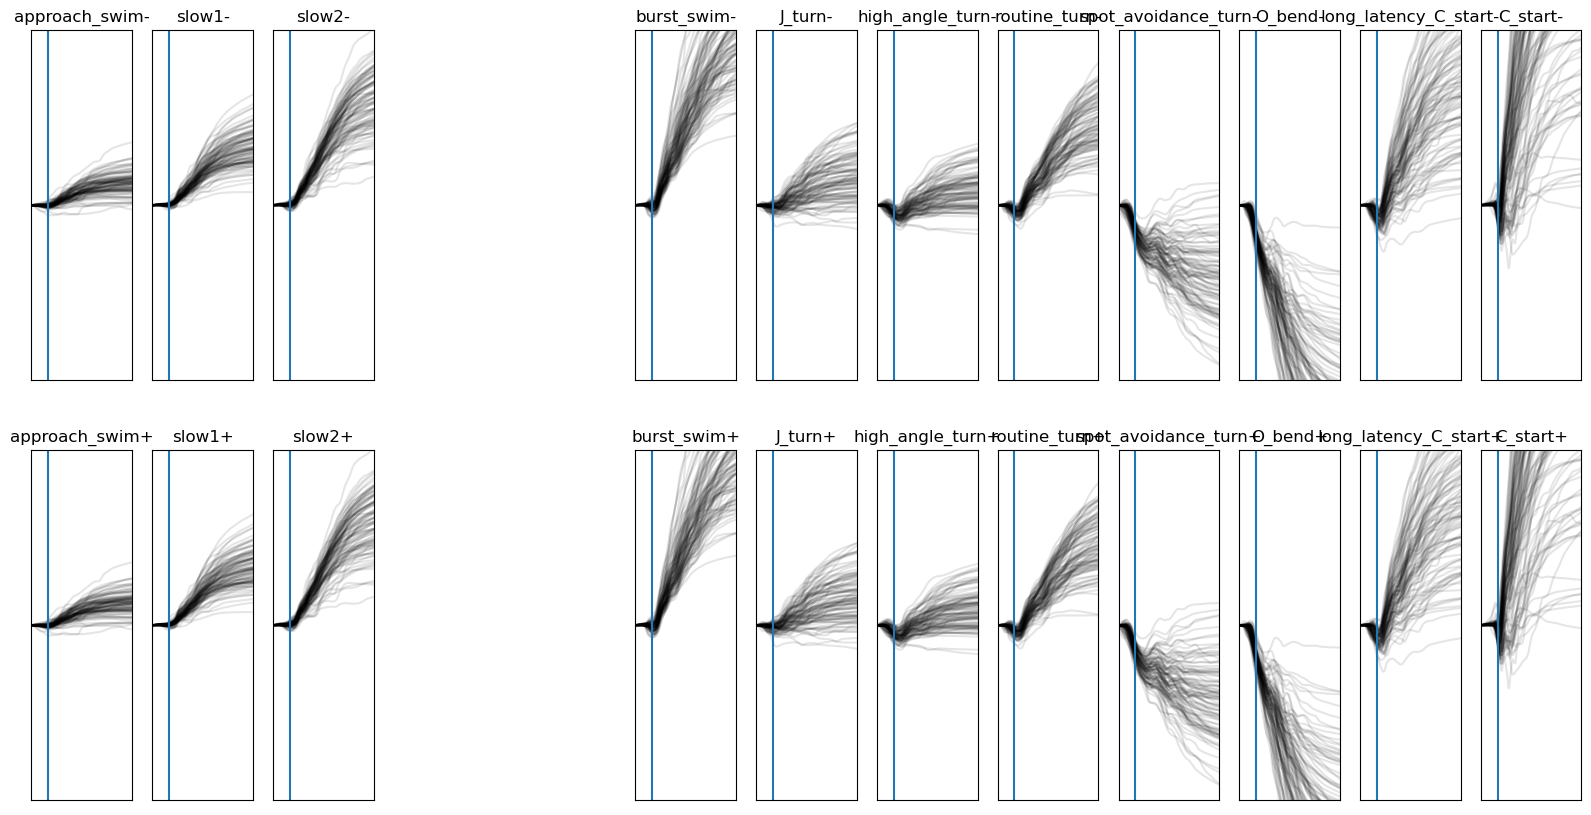

In [26]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = id[0:100]
        ax0.plot(knn_training_dataset.traj[id,0,:].T,'k',alpha=0.1)
        
        
    ax0.vlines(20,-3.6,3.6)
    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [16]:
20*1000/700

28.571428571428573

In [60]:
#np.savez('kNN_Training_Dataset.npz', bouts=balanced_bouts, labels=balanced_labels)


In [61]:
arr = np.load('./classification/TemplateFromkNN_Tu.npz')
#arr = np.load('./classification/kNN_Training_Dataset.npz')


In [62]:
bouts = arr['bouts']
labels = arr['labels']

In [63]:
bouts.shape

(5500, 10, 140)

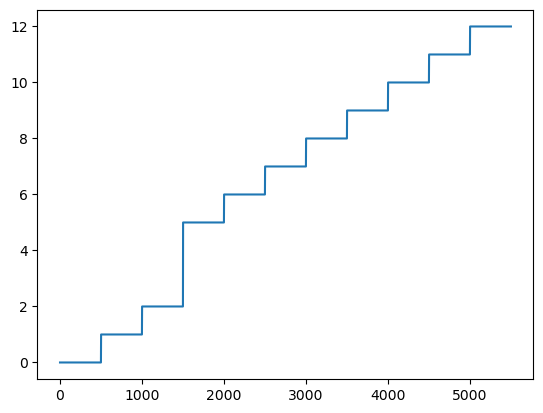

In [64]:
plt.plot(labels)

In [65]:
np.bincount(labels)

array([500, 500, 500,   0,   0, 500, 500, 500, 500, 500, 500, 500, 500],
      dtype=int64)

In [66]:
knn_training_dataset = Knn_Training_Dataset(fps=700,augmentation_delays=[0],ignore_CS=True)

[ 0  1  2  5  6  7  8  9 10 11 12]
(5500, 10, 140)


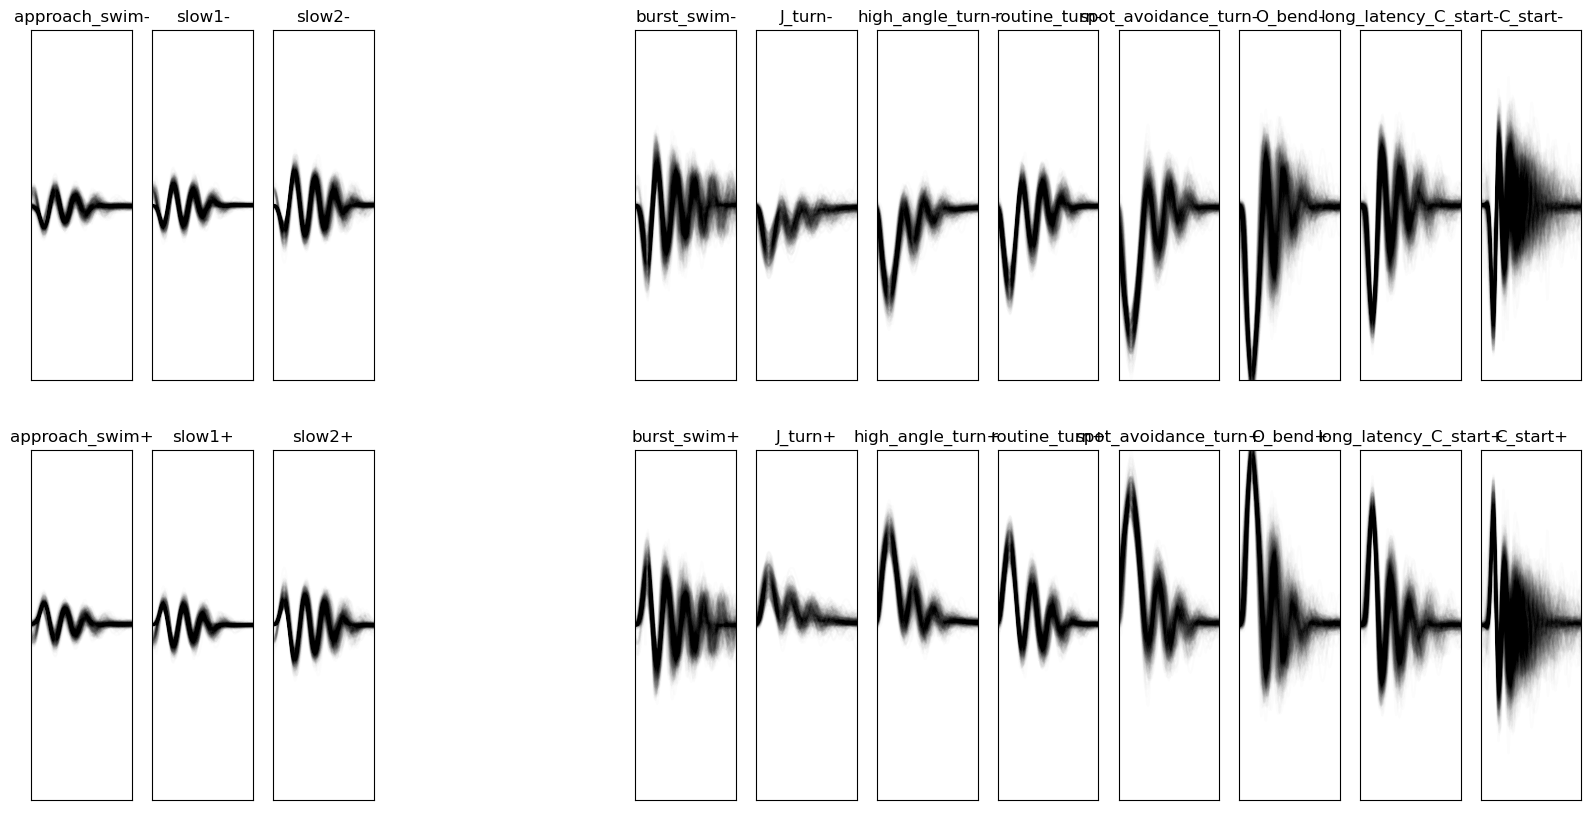

In [67]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(knn_training_dataset.tail[id,-1,:].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Color code

In [68]:
#dict_color_species = {'Tu':'#f94144','Giant':'#90be6d','Danionella':'#277da1'}
dict_color_bouts = {}
dict_color_bouts[0] = '#82cfff'
dict_color_bouts[1] = '#4589ff'
dict_color_bouts[2] = '#0000c8'
dict_color_bouts[3] = '#5d5d66'
dict_color_bouts[4] = '#000000'
dict_color_bouts[5] = '#fcaf6d'
dict_color_bouts[6] = '#ffb3b8'
dict_color_bouts[7] = '#08bdba'
dict_color_bouts[8] = '#24a148'
dict_color_bouts[9] = '#9b82f3'
dict_color_bouts[10] = '#ee5396'
dict_color_bouts[11] = '#e3bc13'
dict_color_bouts[12] = '#fa4d56'

dict_color_bouts[13] = '#82cfff'
dict_color_bouts[14] = '#4589ff'
dict_color_bouts[15] = '#0000c8'
dict_color_bouts[16] = '#5d5d66'
dict_color_bouts[17] = '#000000'
dict_color_bouts[18] = '#fcaf6d'
dict_color_bouts[19] = '#ffb3b8'
dict_color_bouts[20] = '#08bdba'
dict_color_bouts[21] = '#24a148'
dict_color_bouts[22] = '#9b82f3'
dict_color_bouts[23] = '#ee5396'
dict_color_bouts[24] = '#e3bc13'
dict_color_bouts[25] = '#fa4d56'
#dict_color_species = {'Tu':(249/255., 65/255., 68/255.),'Giant':(144/255., 190/255., 109/255.),'Danionella':(39/255., 125/255., 161/255.)}

In [69]:
list_color_no_CS = ['#82cfff','#4589ff','#0000c8','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']
list_color_w_CS = ['#82cfff','#4589ff','#0000c8','#5d5d66','#000000','#fcaf6d','#ffb3b8','#08bdba','#24a148','#9b82f3','#ee5396','#e3bc13','#fa4d56']

NameCatSym_w_CS = []

NameCatSym_w_CS=['approach_swim', 'slow1', 'slow2', 'slow_capture_swim','fast_capture_swim', 'burst_swim', 'J_turn', 'high_angle_turn','routine_turn', 'spot_avoidance_turn', 'O_bend','long_latency_C_start', 'C_start']
NameCatSym_no_CS=['approach_swim', 'slow1', 'slow2', 'burst_swim', 'J_turn', 'high_angle_turn','routine_turn', 'spot_avoidance_turn', 'O_bend','long_latency_C_start', 'C_start']

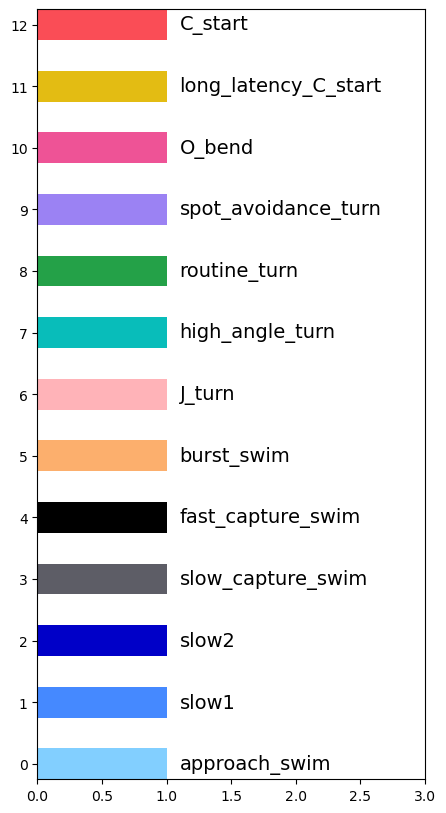

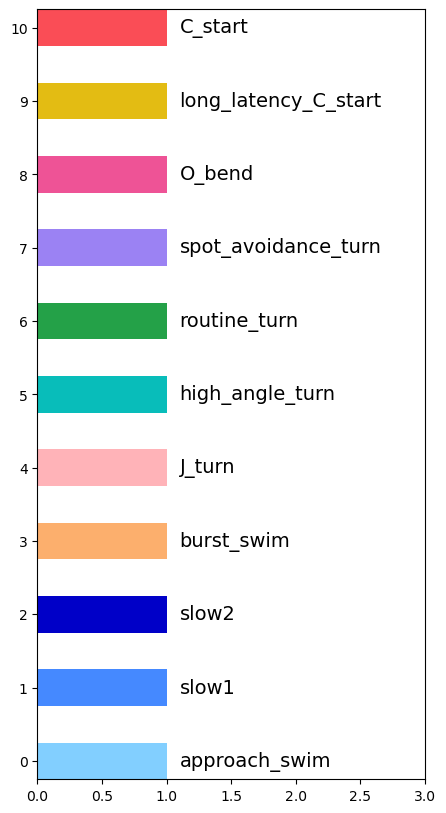

In [70]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(5,10))
for i,c in enumerate(list_color_w_CS):
    ax.add_patch(Rectangle(xy=(0,i*2), width=1,
                      height=1, facecolor=c))
    ax.text(1.1, i*2+0.5, NameCatSym_w_CS[i], fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')                     
ax.set_ylim(0,25)
ax.set_xlim(0,3)
ax.set_yticks(np.arange(0,26,2)+0.5)
ax.set_yticklabels(np.arange(13))
plt.show()

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(5,10))
for i,c in enumerate(list_color_no_CS):
    ax.add_patch(Rectangle(xy=(0,i*2), width=1,
                      height=1, facecolor=c))
    ax.text(1.1, i*2+0.5, NameCatSym_no_CS[i], fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')                     
ax.set_ylim(0,21)
ax.set_xlim(0,3)
ax.set_yticks(np.arange(0,22,2)+0.5)
ax.set_yticklabels(np.arange(11))
plt.show()

# UMAP

In [71]:
import umap


In [72]:
reducer = umap.UMAP(n_components=2,verbose=True)
embedding = reducer.fit_transform(knn_training_dataset.tail_flat)

UMAP( verbose=True)
Tue Nov  8 23:07:08 2022 Construct fuzzy simplicial set
Tue Nov  8 23:07:08 2022 Finding Nearest Neighbors
Tue Nov  8 23:07:08 2022 Building RP forest with 10 trees
Tue Nov  8 23:07:08 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Nov  8 23:07:09 2022 Finished Nearest Neighbor Search
Tue Nov  8 23:07:09 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]


Tue Nov  8 23:07:18 2022 Finished embedding


In [73]:
embedding.shape,labels.shape

((11000, 2), (5500,))

In [74]:
knn_training_dataset.tail.shape

(11000, 7, 140)

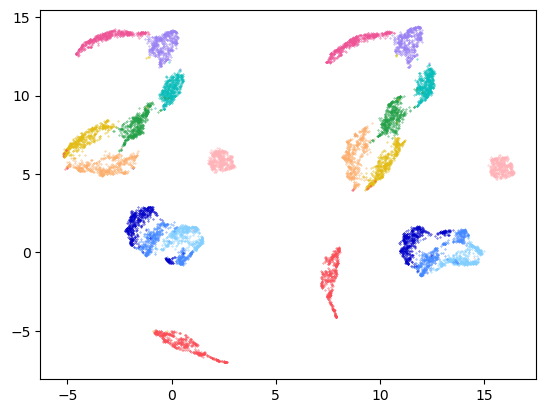

In [75]:
for l in np.unique(knn_training_dataset.labels):
    plt.scatter(embedding[knn_training_dataset.labels==l,0],embedding[knn_training_dataset.labels==l,1],s=0.1,color=dict_color_bouts[l])
plt.show()

<Figure size 1440x1440 with 0 Axes>

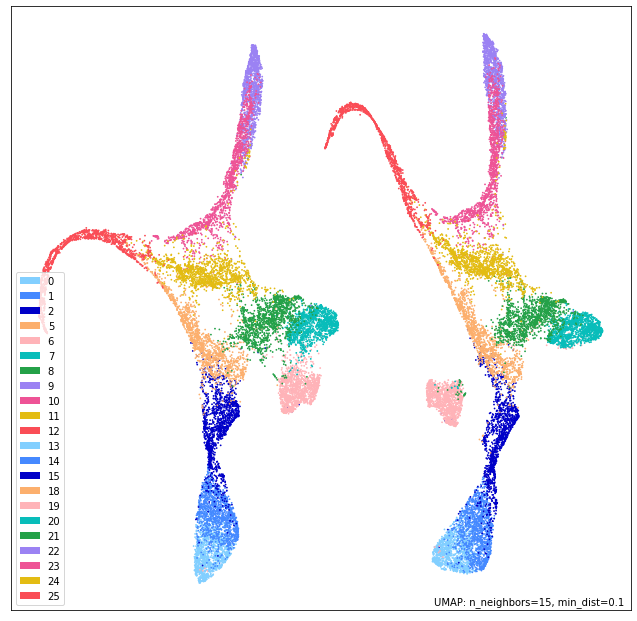

In [ ]:
plt.figure(figsize=(20,20))
#umap.plot.points(reducer,labels=bouts_df.strain,color_key_cmap='plasma')
umap.plot.points(reducer,labels=knn_training_dataset.labels,color_key=dict_color_bouts)
plt.draw()

# Trajectory Template

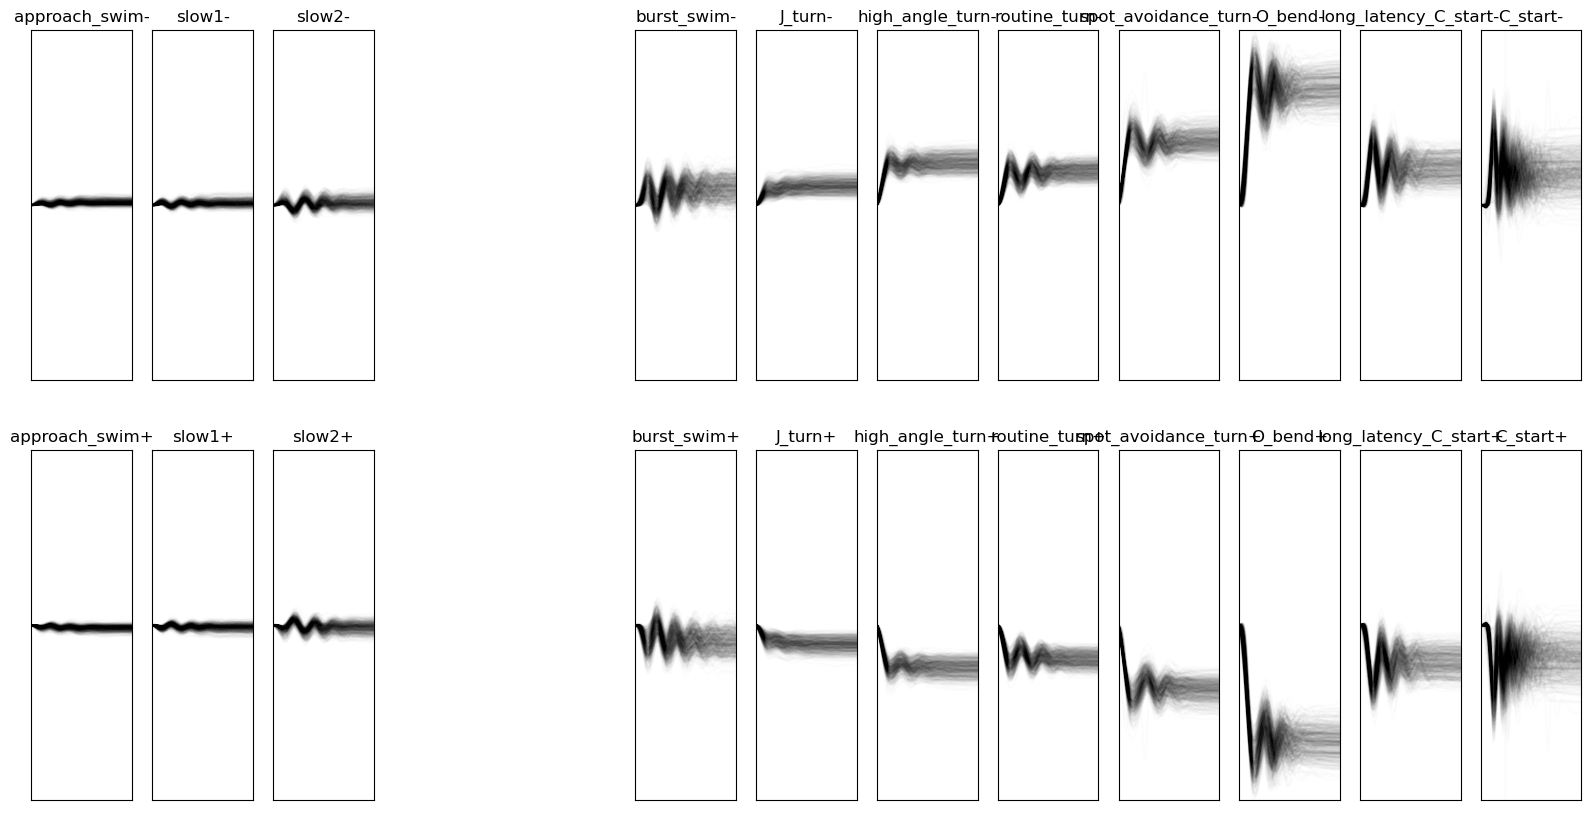

In [76]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(knn_training_dataset.traj[id,-1,:].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [78]:
scale = np.std(np.abs(knn_training_dataset.traj),axis=(0,2))

traj_flat_scaled = knn_training_dataset.traj_flat
traj_flat_scaled[:,0:140] = traj_flat_scaled[:,0:140] /1.6
traj_flat_scaled[:,140:2*140] = traj_flat_scaled[:,140:2*140] /1.9
traj_flat_scaled[:,2*140:] = traj_flat_scaled[:,2*140:] /0.7

In [79]:
reducer = umap.UMAP(n_components=2,verbose=True)
embedding = reducer.fit_transform(knn_training_dataset.traj_flat)

UMAP( verbose=True)
Tue Nov  8 23:08:06 2022 Construct fuzzy simplicial set
Tue Nov  8 23:08:06 2022 Finding Nearest Neighbors
Tue Nov  8 23:08:06 2022 Building RP forest with 10 trees
Tue Nov  8 23:08:07 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Tue Nov  8 23:08:07 2022 Finished Nearest Neighbor Search
Tue Nov  8 23:08:07 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]

Tue Nov  8 23:08:17 2022 Finished embedding


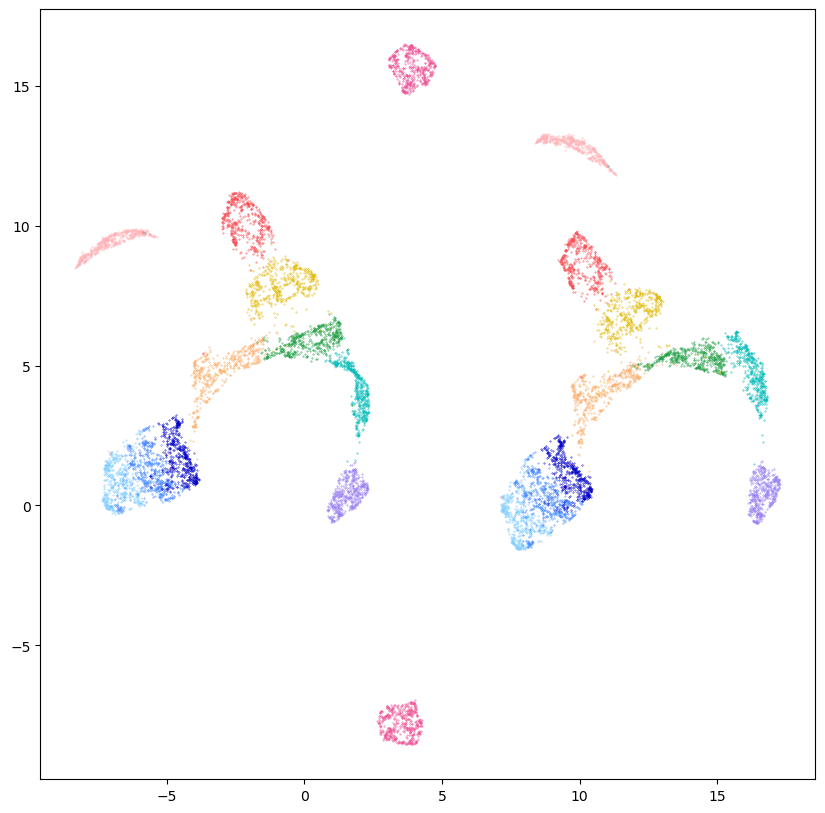

In [89]:
plt.figure(figsize=(10,10))

for l in np.unique(knn_training_dataset.labels):
    plt.scatter(embedding[knn_training_dataset.labels==l,0],embedding[knn_training_dataset.labels==l,1],s=0.1,color=dict_color_bouts[l])
plt.show()

In [80]:
plt.figure(figsize=(20,20))
#umap.plot.points(reducer,labels=bouts_df.strain,color_key_cmap='plasma')
umap.plot.points(reducer,labels=knn_training_dataset.labels,color_key=dict_color_bouts)
plt.draw()

AttributeError: module 'umap' has no attribute 'plot'

<Figure size 2000x2000 with 0 Axes>

# Tail and Traj

In [82]:
reducer = umap.UMAP(n_components=2,verbose=True)
embedding = reducer.fit_transform(knn_training_dataset.tail_and_traj_flat)

UMAP( verbose=True)
Tue Nov  8 23:08:57 2022 Construct fuzzy simplicial set
Tue Nov  8 23:08:57 2022 Finding Nearest Neighbors
Tue Nov  8 23:08:57 2022 Building RP forest with 10 trees
Tue Nov  8 23:08:57 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Nov  8 23:08:58 2022 Finished Nearest Neighbor Search
Tue Nov  8 23:08:58 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]


Tue Nov  8 23:09:07 2022 Finished embedding


In [83]:
knn_training_dataset.tail_and_traj_flat.shape

(11000, 1400)

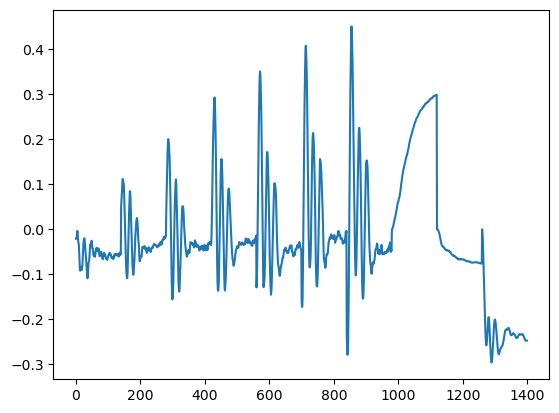

In [84]:
plt.plot(knn_training_dataset.tail_and_traj_flat[0,:])

In [85]:
id = np.arange(6*140,7*140).tolist()+np.arange(9*140,10*140).tolist()
tail_head = knn_training_dataset.tail_and_traj_flat[:,id]

In [86]:
knn_training_dataset.labels.shape[0]/2

5500.0

In [87]:
tail_head = knn_training_dataset.tail_and_traj_flat[:,id]
tail_head = tail_head[0:15400]
label = knn_training_dataset.labels[0:15400]

In [88]:
reducer = umap.UMAP(n_components=2,verbose=True)
embedding = reducer.fit_transform(tail_head)

UMAP( verbose=True)
Tue Nov  8 23:09:10 2022 Construct fuzzy simplicial set
Tue Nov  8 23:09:10 2022 Finding Nearest Neighbors
Tue Nov  8 23:09:10 2022 Building RP forest with 10 trees
Tue Nov  8 23:09:10 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Nov  8 23:09:11 2022 Finished Nearest Neighbor Search
Tue Nov  8 23:09:11 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]

Tue Nov  8 23:09:20 2022 Finished embedding


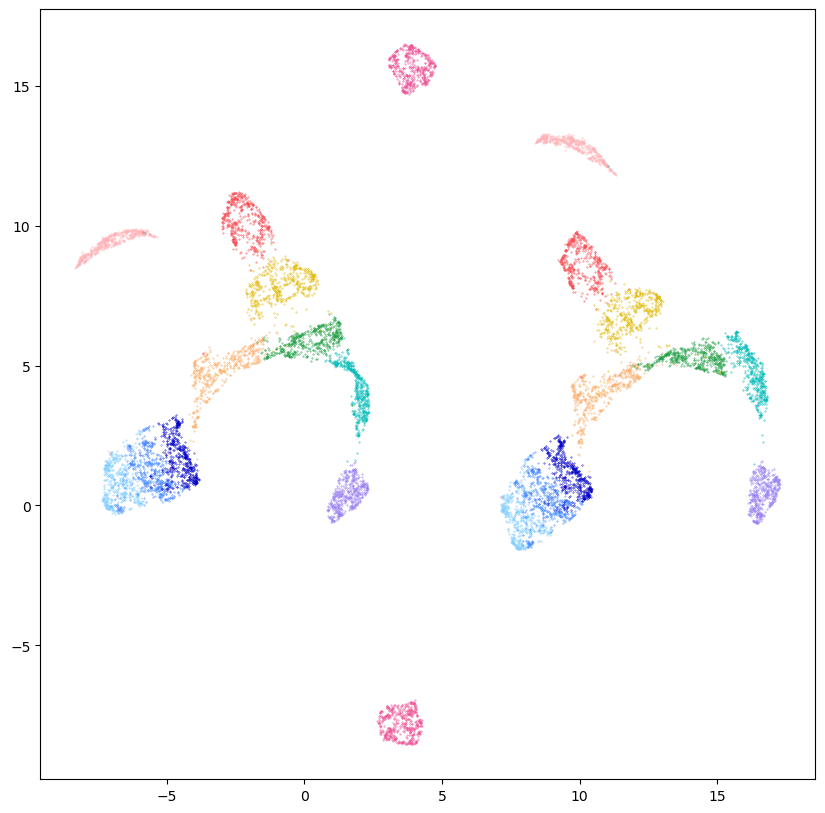

In [90]:
plt.figure(figsize=(10,10))

for l in np.unique(knn_training_dataset.labels):
    plt.scatter(embedding[knn_training_dataset.labels==l,0],embedding[knn_training_dataset.labels==l,1],s=0.1,color=dict_color_bouts[l])
plt.show()

<Figure size 1440x1440 with 0 Axes>

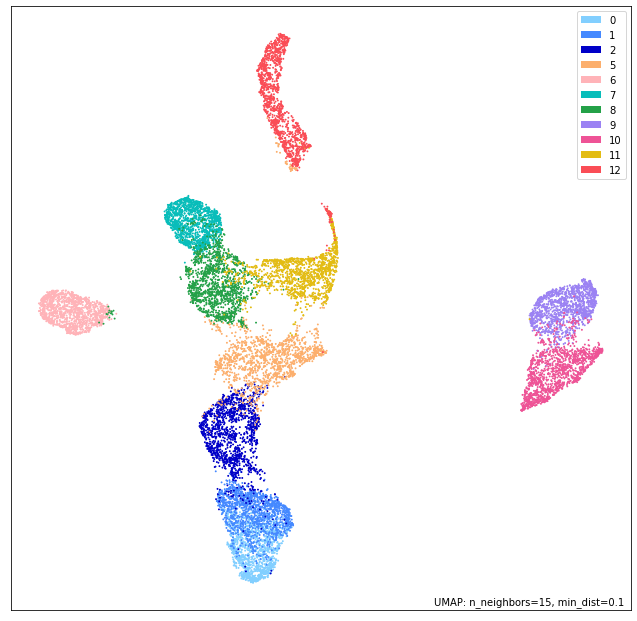

In [51]:
plt.figure(figsize=(20,20))
#umap.plot.points(reducer,labels=bouts_df.strain,color_key_cmap='plasma')
umap.plot.points(reducer,labels=label,color_key=dict_color_bouts)
plt.draw()

# Save for ilqr:

In [42]:
tail = knn_training_dataset.tail
traj = knn_training_dataset.traj
labels = knn_training_dataset.labels
print(tail.shape,traj.shape,labels.shape)

(30800, 7, 140) (30800, 3, 140) (30800,)


9


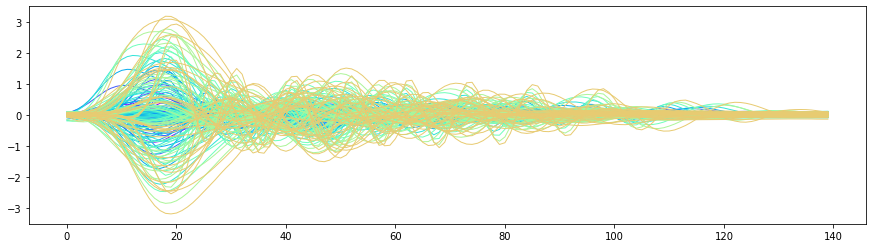

In [62]:
import matplotlib as mpl


cmap = plt.cm.rainbow  
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::30]
print(len(cmaplist))
plt.figure(figsize=(15,4))
for i in range(7):
    plt.plot(tail[::1000,i,:].T,color=cmaplist[i],lw=1)
plt.show()

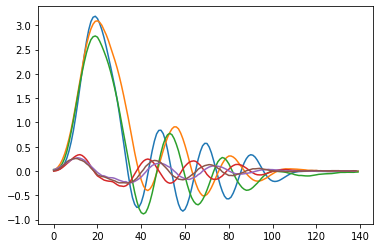

In [74]:
i = np.random.randint(tail.shape[0])
plt.plot(tail[i:i+3,-1,:].T)
plt.plot(np.diff(tail[i:i+3,-1,:]).T)

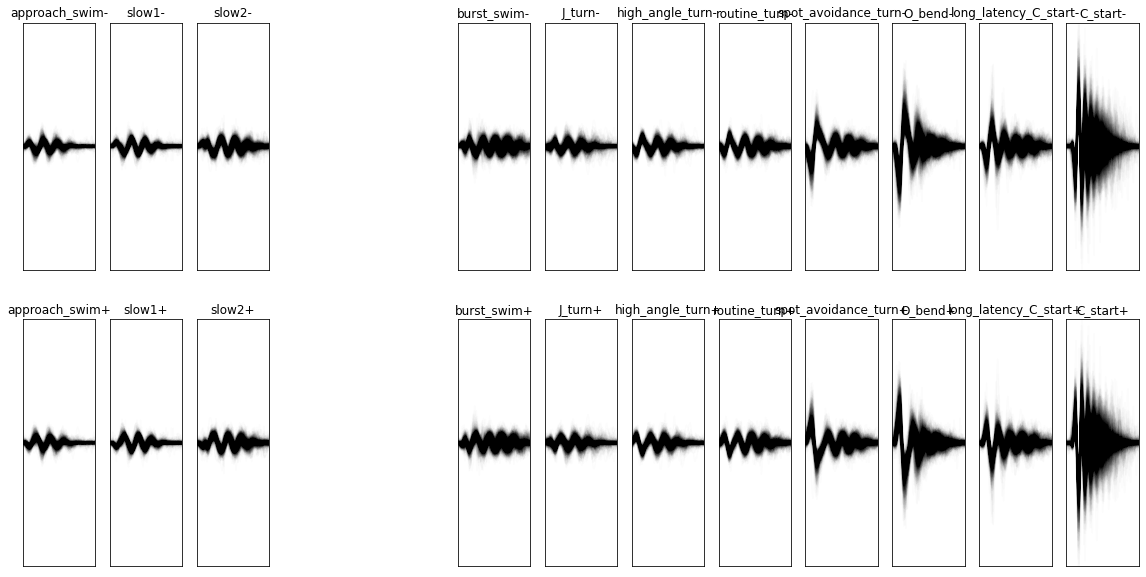

In [77]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(np.diff(knn_training_dataset.tail[id,0,:]).T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-0.3,0.3)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [80]:
# Increase delay before bouts:

balanced_bouts = np.load('balanced_dataset/tail_angle.npy')
balanced_bouts_raw =np.load('balanced_dataset/tail_angle_raw.npy')
balanced_label = np.load('balanced_dataset/bout_category.npy')
balanced_fish_id =  np.load('balanced_dataset/fish_id.npy')

In [97]:
balanced_bouts.shape

(36400, 7, 160)

In [99]:
knn_training_dataset.tail.shape

(30800, 7, 140)

In [184]:

Y = np.zeros((0,140))
Y_no_shift = np.zeros((0,160))
for i in range(20,21):
    Y = np.vstack((Y,balanced_bouts[:,-1,i:i+140]))
    Y_no_shift = np.vstack((Y_no_shift,balanced_bouts[:,-1,:]))


In [185]:
X = knn_training_dataset.tail[:,-1,:]

In [186]:
X.shape,Y.shape

((30800, 140), (36400, 140))

In [187]:
from sklearn.metrics import pairwise_distances_chunked

In [188]:
from sklearn.neighbors import KNeighborsClassifier


In [189]:
##### Compute NN #####
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(Y, np.random.randint(0,10,len(Y)))
res = knn.kneighbors(X[:,:])

id_nearest = res[1][:,0]

In [190]:
X.shape

(30800, 140)

In [191]:
Y.shape

(36400, 140)

In [192]:
id_nearest

array([16471, 22426,  4972, ...,  2570, 24973, 11193], dtype=int64)

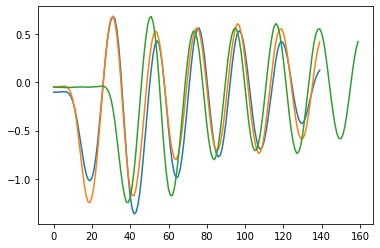

In [195]:
i = np.random.randint(knn_training_dataset.tail.shape[0])
x = knn_training_dataset.tail[i,-1,:]
j = id_nearest[i]#np.argmin(np.linalg.norm(X-x[np.newaxis,:],axis=1))
plt.plot(x)
plt.plot(Y[j,:])
plt.plot(Y_no_shift[j,:])

In [198]:
selected_bouts = balanced_bouts[id_nearest,:,:]
selected_bouts_raw = balanced_bouts_raw[id_nearest,:,:]
selected_labels = knn_training_dataset.labels
selected_fish_id = balanced_fish_id[id_nearest]

selected_approx_traj = knn_training_dataset.traj

In [202]:
selected_bouts.shape

(30800, 7, 160)

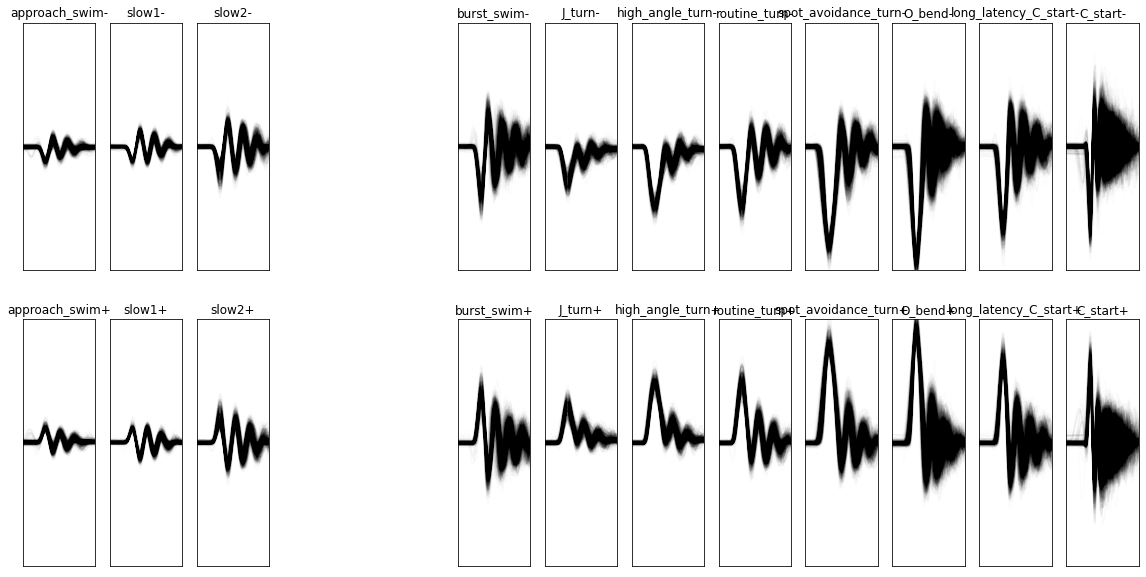

In [200]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique(selected_labels)):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(selected_labels==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(selected_bouts[id,-1,:].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    #ax0.set_ylim(-0.3,0.3)
    ax0.set_ylim(-3.6,3.6)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


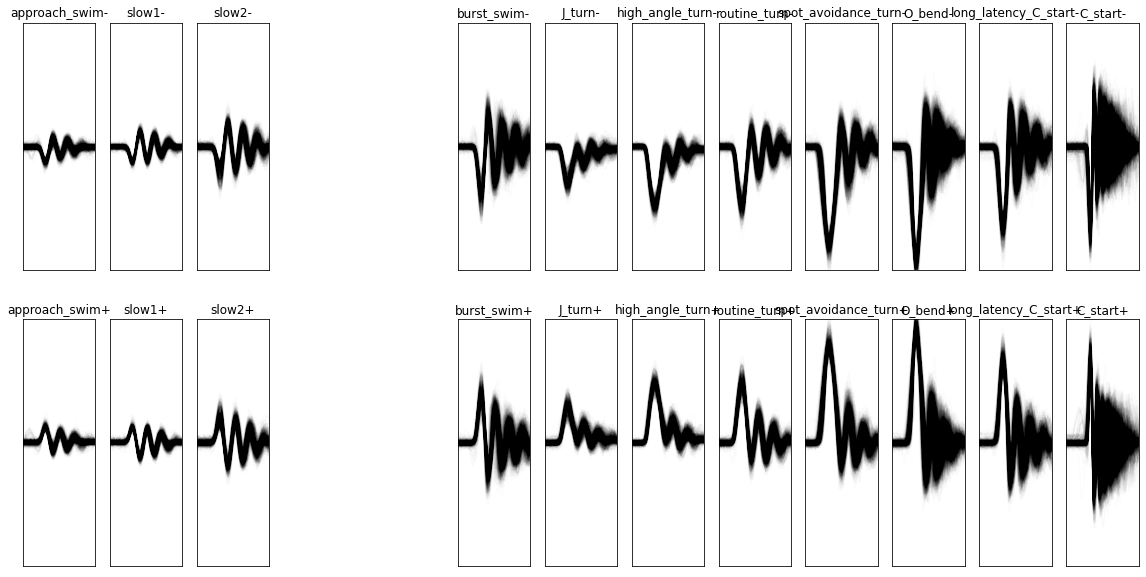

In [201]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique(selected_labels)):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(selected_labels==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(selected_bouts_raw[id,-1,:].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    #ax0.set_ylim(-0.3,0.3)
    ax0.set_ylim(-3.6,3.6)
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [257]:
scale = np.linalg.norm(selected_bouts)/np.linalg.norm(np.diff(selected_bouts,axis=2))
selected_bouts_diff = np.diff(selected_bouts,axis=2)*scale
selected_bouts_raw_diff = np.diff(selected_bouts_raw,axis=2)*scale


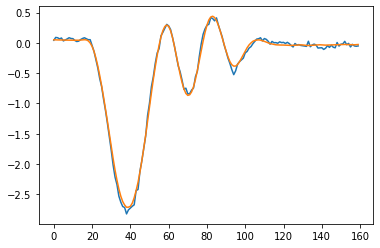

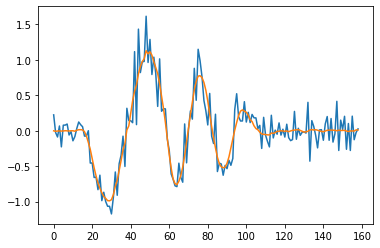

In [260]:
i = np.random.randint(selected_bouts.shape[0])
plt.figure()
plt.plot(selected_bouts_raw[i,-1,:])
plt.plot(selected_bouts[i,-1,:])
plt.show()
plt.figure()
plt.plot(selected_bouts_raw_diff[i,-1,:])
plt.plot(selected_bouts_diff[i,-1,:])
plt.show()
#plt.plot(selected_bouts_raw[i,-1,:])

In [264]:
# Save all:
print(selected_bouts_raw.shape,selected_bouts_raw_diff.shape)
print(selected_bouts.shape,selected_bouts_diff.shape)
print(selected_approx_traj.shape)
print(selected_fish_id.shape)
print(selected_labels.shape)

(30800, 7, 160) (30800, 7, 159)
(30800, 7, 160) (30800, 7, 159)
(30800, 3, 140)
(30800,)
(30800,)


In [267]:
np.save('ilqr_vae_dataset/tail_angle_smooth.npy',selected_bouts)
np.save('ilqr_vae_dataset/tail_angle_raw.npy',selected_bouts_raw)
np.save('ilqr_vae_dataset/tail_angle_smooth_diff.npy',selected_bouts_diff)
np.save('ilqr_vae_dataset/tail_angle_raw_diff.npy',selected_bouts_raw_diff)
np.save('ilqr_vae_dataset/labels.npy',selected_labels)
np.save('ilqr_vae_dataset/fish_id.npy',selected_fish_id)
np.save('ilqr_vae_dataset/approx_traj.npy',selected_approx_traj)